In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from tqdm import tqdm

from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd

import lightgbm as lgb

from catboost import Pool, CatBoostRegressor

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

import matplotlib.pyplot as plt
import seaborn as sns
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils4t import MultipleTimeSeriesCV, format_time
sns.set_style('whitegrid')
YEAR = 252
idx = pd.IndexSlice

In [2]:
data = (pd.read_hdf('data/data.h5', 'model_data').sort_index().loc[idx[:, :'2016'], :])
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1689358 entries, ('A', Timestamp('2010-01-04 00:00:00')) to ('ZION', Timestamp('2016-12-30 00:00:00'))
Data columns (total 34 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol       1689358 non-null  float64
 1   dollar_vol_rank  1689358 non-null  float64
 2   rsi              1675904 non-null  float64
 3   bb_high          1671099 non-null  float64
 4   bb_low           1671097 non-null  float64
 5   NATR             1675904 non-null  float64
 6   ATR              1675904 non-null  float64
 7   PPO              1665333 non-null  float64
 8   MACD             1657645 non-null  float64
 9   sector           1689358 non-null  int32  
 10  r01              1689357 non-null  float64
 11  r05              1689353 non-null  float64
 12  r10              1689348 non-null  float64
 13  r21              1689337 non-null  float64
 14  r42              1689316 non-null  float6

In [3]:
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist() # extracting labels that contain _fwd

tickers = data.index.get_level_values('symbol').unique()

# predict 1, 5, 21 day returns
lookaheads = [1, 5, 21]
categoricals = ['year', 'month', 'sector', 'weekday']

# set train period for 4.5y & test period 3, 1 months
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63, 21]
test_params = list(product(lookaheads, train_lengths, test_lengths))

results_path = Path('results', 'us_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [4]:
train_lengths

[1134, 252]

In [5]:
# Baseline: Linear Regression
lr = LinearRegression()

lr_metrics = []

# iterate over our three CV configuration parameters
for lookahead, train_length, test_length in tqdm(test_params):
    label = f'r{lookahead:02}_fwd'
    df = pd.get_dummies(data.loc[:, features + [label]].dropna(), columns=categoricals, drop_first=True)
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits, test_period_length=test_length, lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([lookahead, train_length, test_length, np.mean(ic),
                       spearmanr(preds.y_true, preds.y_pred)[0]])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

100%|██████████| 12/12 [06:29<00:00, 32.47s/it]


Text(0, 0.5, '')

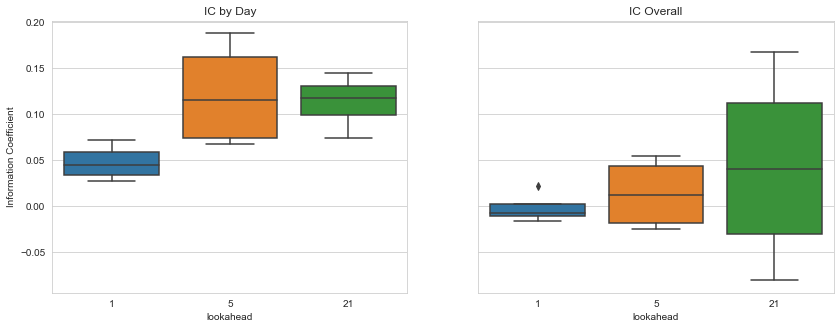

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5), sharey=True)

# plot average of daily IC values
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')

# plot IC across all predictions
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')

In [7]:
# top3 perofrmance in Train/Test Period Lengths
(lr_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic_by_day')))
lr_metrics.to_csv(results_path / 'lin_reg_metrics.csv', index=False)

In [8]:
# LightGBM Model Tuning
def get_fi(model):
    """Return normalized feature importance as pd.Series"""
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(), index=model.feature_name()))

# Hyperparameter opt
base_params = dict(boosting='gbdt', objective='regression', verbose=-1, device='gpu')

# constraints on structure (depth) of each tree
max_depths = [2, 3, 5, 7]
num_leaves_opts = [2 ** i for i in max_depths]
min_data_in_leaf_opts = [250, 500, 1000]

# weight of each new tree in the ensemble
learning_rate_ops = [.01, .1, .3]

# random feature selection
feature_fraction_opts = [.3, .6, .95]
param_names = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']
cv_params = list(product(learning_rate_ops, num_leaves_opts, feature_fraction_opts, min_data_in_leaf_opts))
n_params = len(cv_params)
print(f'# Parameters: {n_params}')

# Parameters: 108


In [9]:
# Train/Test Period Lengths
lookaheads = [1, 5, 21]
label_dict = dict(zip(lookaheads, labels))
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63]
test_params = list(product(lookaheads, train_lengths, test_lengths))
n = len(test_params)
test_param_sample = np.random.choice(list(range(n)), size=int(n), replace=False)
test_params = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params))

Train configs: 6


In [10]:
# Categorical Variables
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

# Custom Loss Function: Information Coefficient
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

# Run Cross-Validation
lgb_store = Path(results_path / 'tuning_lgb.h5')
labels = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(labels).tolist()
label_dict = dict(zip(lookaheads, labels))
num_iterations = [10, 25, 50, 75] + list(range(100, 501, 50))
num_boost_round = num_iterations[-1]
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] + [str(n) for n in num_iterations])

In [ ]:
for lookahead, train_length, test_length in test_params:
    # randomized grid search
    cvp = np.random.choice(list(range(n_params)), size=int(n_params / 2), replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    # set up cross-validation
    n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | Test: {test_length:2.0f} | '
          f'Params: {len(cv_params_):3.0f} | Train configs: {len(test_params)}')

    # time-series cross-validation
    cv = MultipleTimeSeriesCV(n_splits=n_splits, lookahead=lookahead, test_period_length=test_length,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()

    # binary dataset
    lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1), label=outcome_data[label],
                           categorical_feature=categoricals, free_raw_data=False)
    T = 0
    predictions, metrics, feature_importance, daily_ic = [], [], [], []

    # iterate over (shuffled) hyperparameter combinations
    for p, param_vals in enumerate(cv_params_):
        key = f'{lookahead}/{train_length}/{test_length}/' + '/'.join([str(p) for p in param_vals])
        params = dict(zip(param_names, param_vals))
        params.update(base_params)


        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)

        # iterate over folds
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):

            # select train subset
            lgb_train = lgb_data.subset(used_indices=train_idx.tolist(), params=params).construct()

            # train model for num_boost_round
            model = lgb.train(params=params, train_set=lgb_train, num_boost_round=num_boost_round,
                              verbose_eval=False)
            # log feature importance
            if i == 0:
                fi = get_fi(model).to_frame()
            else:
                fi[i] = get_fi(model)

            # capture predictions
            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_name()]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}

            # record predictions for each fold
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))

        # combine fold results
        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)

        # compute IC per day
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()

        # compute IC across all predictions
        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        t = time() - start
        T += t

        # collect metrics
        metrics = pd.Series(list(param_vals) + [t, daily_ic_mean.max(), daily_ic_mean_n, daily_ic_median.max(),
                             daily_ic_median_n] + ic, index=metric_cols)
        msg = f'\t{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["learning_rate"]:5.2f} | '
        msg += f'{params["num_leaves"]:3.0f} | {params["feature_fraction"]:3.0%} | '
        msg += f'{params["min_data_in_leaf"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | '
        msg += f'{ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)

        # persist results for given CV run and hyperparameter combination
        metrics.to_hdf(lgb_store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(lgb_store, 'daily_ic/' + key)
        fi.T.describe().T.assign(**params).to_hdf(lgb_store, 'fi/' + key)
        cv_preds.to_hdf(lgb_store, 'predictions/' + key)

Lookahead:  1 | Train: 1134 | Test: 63 | Params:  54 | Train configs: 6
	  0 | 00:00:49 ( 49) |  0.30 |   4 | 95% | 1000 |   2.07% |  1.55% |  300 |  2.09% |  500
	  1 | 00:01:39 ( 50) |  0.01 |   4 | 60% |  500 |   1.28% |  0.85% |  100 |  0.76% |  200
	  2 | 00:02:26 ( 47) |  0.10 |   4 | 60% |  500 |   3.07% |  2.00% |  450 |  1.80% |  450
	  3 | 00:05:26 (180) |  0.10 | 128 | 95% |  250 |   3.35% |  1.63% |   50 |  1.96% |  250
	  4 | 00:06:24 ( 57) |  0.01 |   8 | 30% |  500 |   1.01% |  1.27% |  350 |  1.01% |  350
	  5 | 00:07:19 ( 55) |  0.10 |   8 | 30% |  250 |   2.13% |  1.42% |  100 |  1.61% |  200
	  6 | 00:10:21 (182) |  0.10 | 128 | 95% |  500 |   3.50% |  1.37% |   50 |  1.61% |  450
	  7 | 00:13:25 (184) |  0.10 | 128 | 60% |  250 |   3.53% |  1.06% |  100 |  1.63% |  350
	  8 | 00:14:24 ( 59) |  0.10 |   8 | 30% | 1000 |   2.97% |  1.56% |  450 |  1.89% |  450
	  9 | 00:15:42 ( 78) |  0.01 |   8 | 30% | 1000 |   1.57% |  1.37% |  400 |  1.01% |  500
	 10 | 00:17:05 ( 

In [ ]:
key

In [ ]:
# CatBoost Model Tuning

# Hyperparameter Opts
param_names = ['max_depth', 'min_child_samples']

max_depth_opts = [3, 5, 7, 9]
min_child_samples_opts = [20, 250, 500]
cv_params = list(product(max_depth_opts, min_child_samples_opts))
n_params = len(cv_params)

# Train/Test Period Lengths
lookaheads = [1, 5, 21]
label_dict = dict(zip(lookaheads, labels))
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63]
test_params = list(product(lookaheads, train_lengths, test_lengths))

# Custom Loss Function
class CatBoostIC(object):
    """Custom IC eval metric for CatBoost"""

    def is_max_optimal(self):
        # Returns whether great values of metric are better
        return True

    def evaluate(self, approxes, target, weight):
        target = np.array(target)
        approxes = np.array(approxes).reshape(-1)
        rho = spearmanr(approxes, target)[0]
        return rho, 1

    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return error

# Run Cross-Validation
cb_store = Path(results_path / 'tuning_catboost.h5')
num_iterations = [10, 25, 50, 75] + list(range(100, 1001, 100))
num_boost_round = num_iterations[-1]
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] + [str(n) for n in num_iterations])

In [ ]:
metric_cols

In [ ]:
num_iterations

In [ ]:
for lookahead, train_length, test_length in test_params:
    cvp = np.random.choice(list(range(n_params)), size=int(n_params / 1), replace=False)
    print(f'cvp: {cvp}')
    cv_params_ = [cv_params[i] for i in cvp]
    print(f'cv_params_: {cv_params_}\n')

    n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f} | Train configs: {len(test_params)}')

    cv = MultipleTimeSeriesCV(n_splits=n_splits, lookahead=lookahead, test_period_length=test_length,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()
    cat_cols_idx = [outcome_data.columns.get_loc(c) for c in categoricals]
    catboost_data = Pool(label=outcome_data[label], data=outcome_data.drop(label, axis=1),
                         cat_features=cat_cols_idx)
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    key = f'{lookahead}/{train_length}/{test_length}'
    T = 0
    for p, param_vals in enumerate(cv_params_):
        params = dict(zip(param_names, param_vals))
        params['task_type'] = 'GPU'

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            train_set = catboost_data.slice(train_idx.tolist())

            model = CatBoostRegressor(**params)
            model.fit(X=train_set, verbose_eval=False)

            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_names_]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, ntree_end=n) for n in num_iterations}
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))

        cv_preds = pd.concat(cv_preds).assign(**params)

        predictions.append(cv_preds)
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()

        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        t = time() - start
        T += t
        metrics = pd.Series(list(param_vals) + [t, daily_ic_mean.max(), daily_ic_mean_n,
                             daily_ic_median.max(), daily_ic_median_n] + ic, index=metric_cols)
        msg = f'{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["max_depth"]:3.0f} | '
        msg += f'{params["min_child_samples"]:4.0f} | {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | '
        msg += f'{daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)
        metrics.to_hdf(cb_store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(cb_store, 'daily_ic/' + key)
        cv_preds.to_hdf(cb_store, 'predictions/' + key)


print("results: " , pd.concat([metrics.tail(), cv_preds]))